# Filtros en Arduino

Para filtrar datos de sensores en Arduino, es común aplicar algunos métodos matemáticos que ayudan a suavizar o limpiar los datos antes de usarlos. Aquí te explico algunos conceptos y cómo implementarlos, por ejemplo:

- **Promedio simple** y **mediana**, útiles para un filtrado rápido y sencillo.
- **Media móvil** y **filtro pasa bajo**, útiles para suavizar los datos de sensores en tiempo real.
- **Desviación estándar**, permite medir la dispersión de las lecturas.
- **Filtro de la mediana móvil** y **filtro de Kalman**, métodos más avanzados para eliminar ruido y valores atípicos.

Además, se puede aprender más sobre el filtrado de señales analógicas en [The 101 of analog signal filtering](https://lcamtuf.substack.com/p/the-101-of-analog-signal-filtering) y [Analog filters, part 2: let it ring](https://lcamtuf.substack.com/p/analog-filters-part-2-let-it-ring).

## Promedio simple de *n* elementos
El promedio simple (o media básica) toma la suma de los últimos `n` elementos y la divide entre `n`. Esto ayuda a suavizar las lecturas ruidosas. Este método permite sacar la media de una serie de números, y mientras menos números se utilicen, más baja será su precisión. Más información [aquí](https://www.electrosoftcloud.com/mejorar-las-lecturas-analogicas-de-tu-arduino-parte-2/).

**Fórmula:**
$$ \text{Promedio simple} = \frac{x_1 + x_2 + \cdots + x_n}{n} $$

In [ ]:
float promedioSimple(float* datos, int n) {
  float suma = 0.0;
  for (int i = 0; i < n; i++) {
    suma += datos[i];
  }
  return suma / n;
}

Por ejemplo, si tenemos 4 mediciones analógicas, y una de ellas (`n3`) sufre una interferencia y recibimos un pico durante la medición, el resultado será: 

$$ \text{media} = \frac{123 + 125 + 220 + 121}{4} \approx 147 $$

El mismo ejemplo pero usando más cantidad de muestras (`10`) atenuará el pico:

$$ \text{media} = \frac{123 + 125 + 220 + 121 + 120 + 127 + 123 + 121 + 125 + 120}{10} \approx 132 $$

**Ejemplo de implementación en Arduino:**

In [ ]:
const byte SENSOR = A0;

void setup() {
    Serial.begin(9600);
}

void loop() {

    int lecturas[10];
    int suma, media;

    Serial.print("Lecturas: ");
    for (byte i = 0; i < 10; i++) {
        lecturas[i] = analogRead(SENSOR);
        suma += lecturas[i];
        Serial.print(lecturas[i]);
        Serial.print(", ");
        delay(10);
    }

    media = suma / 10;
    Serial.println();
    Serial.print("La media de la lectura es: ");
    Serial.println(media);

    delay(1000);
}

**Ejemplo en Python:**

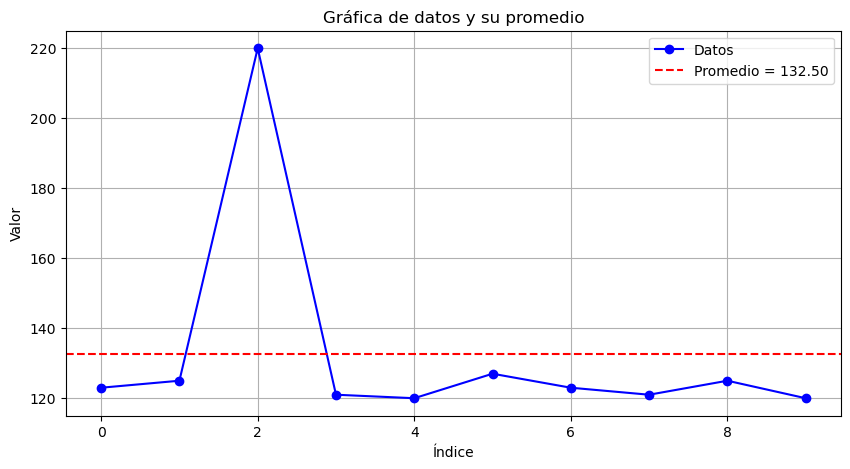

In [1]:
import matplotlib.pyplot as plt

# Datos originales
datos = [123, 125, 220, 121, 120, 127, 123, 121, 125, 120]
promedio = sum(datos) / len(datos)

# Crear la gráfica de los datos y el promedio
plt.figure(figsize=(10, 5))
plt.plot(datos, marker='o', label='Datos', linestyle='-', color='blue')
plt.axhline(y=promedio, color='red', linestyle='--', label=f'Promedio = {promedio:.2f}')

# Configuración de la gráfica
plt.title('Gráfica de datos y su promedio')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

## Promedio ponderado

El promedio ponderado da más importancia a algunos valores. Esto puede ser útil cuando quieres darle más peso a los datos más recientes, que podrían ser más relevantes.

**Fórmula:**
$$
 \text{Promedio ponderado} = \frac{\sum (dato \times peso)}{\sum (pesos)}
$$
$$
\text{Promedio ponderado} = \frac{w_1 \cdot x_1 + w_2 \cdot x_2 + \cdots + w_n \cdot x_n}{w_1 + w_2 + \cdots + w_n}
$$
Donde $w_i$ es el peso asignado a cada valor $x_i$.

**Ejemplo de implementación en Arduino:**

In [ ]:
float promedioPonderado(float* datos, float* pesos, int n) {
  float sumaPesos = 0.0, sumaDatos = 0.0;
  for (int i = 0; i < n; i++) {
    sumaDatos += datos[i] * pesos[i];
    sumaPesos += pesos[i];
  }
  return sumaDatos / sumaPesos;
}

**Ejemplo en Python:**

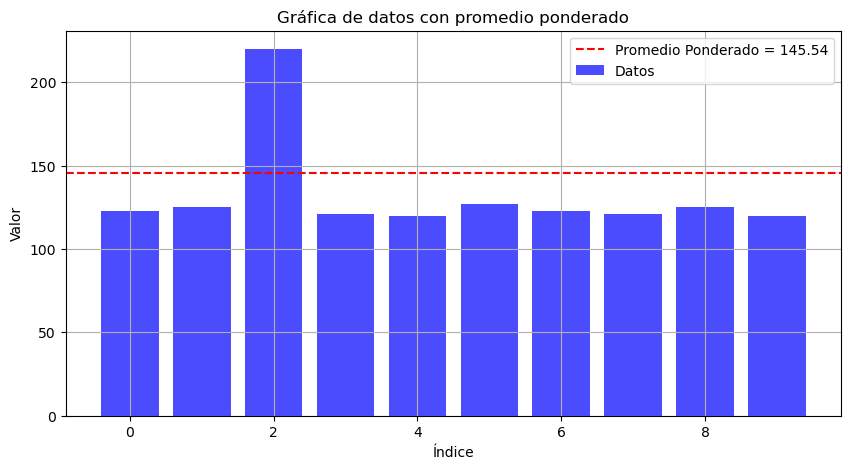

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Datos y sus pesos
datos = [123, 125, 220, 121, 120, 127, 123, 121, 125, 120]
pesos = [1, 1, 3, 1, 1, 2, 1, 1, 1, 1]  # Pesos asignados a cada dato

# Calcular el promedio ponderado
promedio_ponderado = np.average(datos, weights=pesos)

# Crear la gráfica
plt.figure(figsize=(10, 5))
plt.bar(range(len(datos)), datos, color='blue', alpha=0.7, label='Datos')
plt.axhline(y=promedio_ponderado, color='red', linestyle='--', label=f'Promedio Ponderado = {promedio_ponderado:.2f}')

# Configuración de la gráfica
plt.title('Gráfica de datos con promedio ponderado')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

## Media móvil (Moving Average)

La media móvil toma un número de lecturas y calcula el promedio de las últimas `n` lecturas. Se usa mucho para suavizar fluctuaciones rápidas en los datos de sensores. Este método mantiene un buffer de los últimos `n` datos y lo actualiza con cada nueva lectura.

Su fórmula es:

$$
\text{Media móvil en el punto } t = \frac{\sum_{i=t-k+1}^{t} x_i}{k}
$$

Donde:

- $ x_i $: Son los valores de los datos.
- $ k $: Tamaño de la ventana.
- $ t $: Índice actual de la serie de datos.

**Ejemplo de implementación en Arduino:**

In [ ]:
float mediaMovil(float nuevoDato, float* buffer, int n) {
  float suma = 0.0;
  
  // Desplazar el buffer
  for (int i = n - 1; i > 0; i--) {
    buffer[i] = buffer[i - 1];
  }
  
  // Añadir el nuevo dato
  buffer[0] = nuevoDato;
  
  // Calcular el promedio
  for (int i = 0; i < n; i++) {
    suma += buffer[i];
  }
  
  return suma / n;
}

**Ejemplo en Python:**

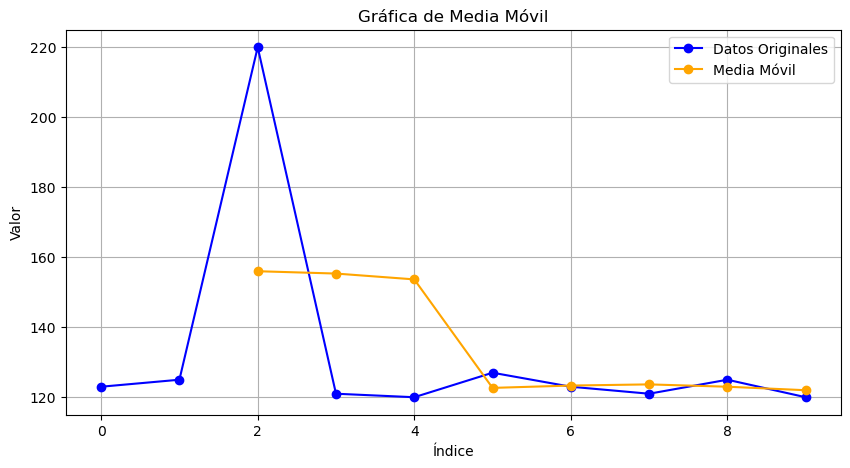

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Datos originales
datos = [123, 125, 220, 121, 120, 127, 123, 121, 125, 120]

# Definir el tamaño de la ventana
ventana = 3

# Calcular la media móvil
media_movil = np.convolve(datos, np.ones(ventana)/ventana, mode='valid')

# Crear la gráfica
plt.figure(figsize=(10, 5))
plt.plot(datos, marker='o', label='Datos Originales', linestyle='-', color='blue')
plt.plot(range(ventana - 1, len(datos)), media_movil, marker='o', label='Media Móvil', linestyle='-', color='orange')

# Configuración de la gráfica
plt.title('Gráfica de Media Móvil')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

## Media móvil exponencial (Exponential Moving Average, EMA)

La media básica es un poco imprecisa y vulnerable a picos en las mediciones, depende de hacer muchas mediciones para sacar una media más precisa. Es posible utilizar la media móvil exponencial, que es una técnica de suavizado que da más peso a las observaciones recientes. Su fórmula es:

$$
EMA_t = \alpha \cdot x_t + (1 - \alpha) \cdot EMA_{t-1}
$$

$$ \text{media} = (alfa * medición2) + ((1 - alfa) * medida1) $$

Donde `alfa` es un número `float` entre `0` y `1`, siendo lo más usado `0.05` o `0.1`. En sintesis lo que se hace es tomar la nueva medición (`medición2`) y multiplicarla por `alfa`, es decir que sacamos un porcentaje (`0.05 = 5%`). Luego se suma esa cantidad al porcentaje restante (`1 – 0.05 = 0.95 = 95%`) de la medición antigua (`medición1`). Con esto se consegue que sólo una parte de la medición nueva afecte al resultado final, y por supuesto, cuanto más alto sea alfa, más afectará. Normalmente como medición antigua utilizamos la media básica.

Por ejemplo:

$$ \text{media} = (220 * 0.05) + ((1 - 0.05) * 123) = 127.85 $$
$$ \text{media} = (125 * 0.05) + ((1 - 0.05) * 127.85) = 127.70 $$
$$ \text{media} = (121 * 0.05) + ((1 - 0.05) * 127.70) = 127.37 \rightarrow int \rightarrow 127 $$

Resumiendo, el alfa controla cómo de estable es la media. Cuanto más alto sea alfa, más fluctuará, por lo que dependiendo del uso se puede ajustar. Por ejemplo, para un higrómetro o un termómetro nos vendrá bien que este número sea bajo porque su variación es lenta y muy baja, pero para otros casos como por ejemplo medir el voltaje de algo conectado nos puede venir mejor subirlo para detectar los cambios antes. Más info [aquí](https://www.electrosoftcloud.com/mejorar-las-lecturas-analogicas-de-tu-arduino-parte-2/).

**Ejemplo de implementación en Arduino:**

In [ ]:
const int SENSOR = A0;

void setup() {
  Serial.begin(9600);
}

void loop() {

  int lecturas[10];
  float alfa = 0.1;

  // Llenamos el array con números aleatorios, sólo con fines de simulación
  for (byte i = 0; i < 10; i++) {
    lecturas[i] = random(50, 60);
    Serial.println(lecturas[i]);
  }

  // Sacamos la primera media entre los dos primeros números
  float media = (alfa * lecturas[1]) + ((1 - alfa) * lecturas[0]);

  // Realizamos la media móvil exponencial usando el resto de números
  for (byte i = 0; i < 10; i++) {
    media = (alfa * lecturas[i]) + ((1 - alfa) * media);
  }

  Serial.print("La media móvil exponencial es:");
  Serial.println(media);

  delay(5000); // Sólo a fines de simulación

}

**Ejemplo en Python:**

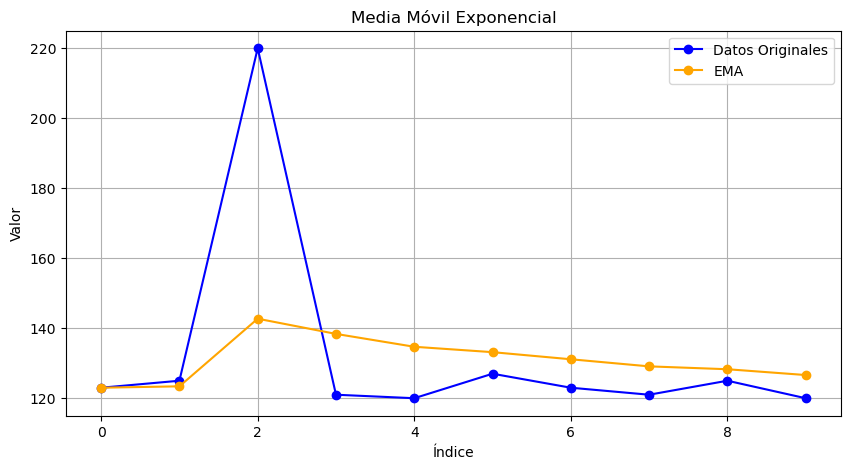

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Datos originales
datos = [123, 125, 220, 121, 120, 127, 123, 121, 125, 120]

# Parámetro de suavizado (alpha)
alpha = 0.2

# Calcular EMA manualmente
ema = []
for i, x in enumerate(datos):
    if i == 0:
        ema.append(x)  # El primer valor de EMA es igual al primer dato
    else:
        ema.append(alpha * x + (1 - alpha) * ema[-1])

# Crear la gráfica
plt.figure(figsize=(10, 5))
plt.plot(datos, marker='o', label='Datos Originales', linestyle='-', color='blue')
plt.plot(ema, marker='o', label='EMA', linestyle='-', color='orange')

# Configuración de la gráfica
plt.title('Media Móvil Exponencial')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

## Mediana

La mediana es el valor que se encuentra en el medio de un conjunto de datos ordenados. Si hay un número impar de valores, la mediana es el valor del centro. Si hay un número par, es el promedio de los dos valores del centro.

**Ejemplo de implementación en Arduino:**

In [ ]:
float mediana(float* datos, int n) {

  // Primero ordenamos el arreglo
  for (int i = 0; i < n - 1; i++) {
    for (int j = i + 1; j < n; j++) {
      if (datos[i] > datos[j]) {
        float temp = datos[i];
        datos[i] = datos[j];
        datos[j] = temp;
      }
    }
  }
  
  // Si n es impar, devolvemos el elemento del centro
  if (n % 2 == 1) {
    return datos[n / 2];
  }
  // Si n es par, devolvemos el promedio de los dos del centro
  else {
    return (datos[(n - 1) / 2] + datos[n / 2]) / 2.0;
  }
}

**Ejemplo en Python:**

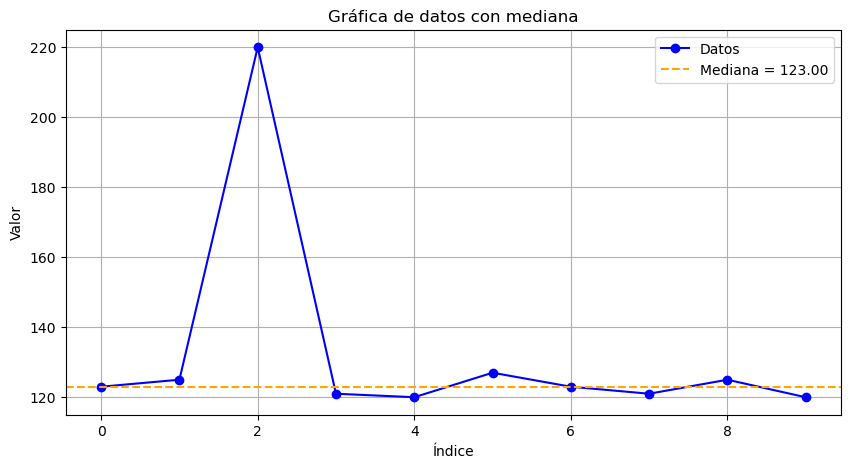

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Datos originales
datos = [123, 125, 220, 121, 120, 127, 123, 121, 125, 120]

# Calcular la mediana
mediana = np.median(datos)

# Crear la gráfica
plt.figure(figsize=(10, 5))
plt.plot(datos, marker='o', label='Datos', linestyle='-', color='blue')
plt.axhline(y=mediana, color='orange', linestyle='--', label=f'Mediana = {mediana:.2f}')

# Configuración de la gráfica
plt.title('Gráfica de datos con mediana')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()


## Desviación estándar

La desviación estándar mide la dispersión de un conjunto de datos respecto a su media. Es útil para entender qué tan dispersos están los datos de los sensores.

**Fórmula:**
$$
\text{Desviación estándar} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_i - \mu)^2}
$$
Donde $\mu$ es la media de los datos.

**Ejemplo de implementación en Arduino:**

In [ ]:
float desviacionEstandar(float* datos, int n) {
  float suma = 0.0, sumaCuadrados = 0.0;
  for (int i = 0; i < n; i++) {
    suma += datos[i];
  }
  float media = suma / n;
  for (int i = 0; i < n; i++) {
    sumaCuadrados += pow(datos[i] - media, 2);
  }
  return sqrt(sumaCuadrados / n);
}

**Ejemplo en Python:**

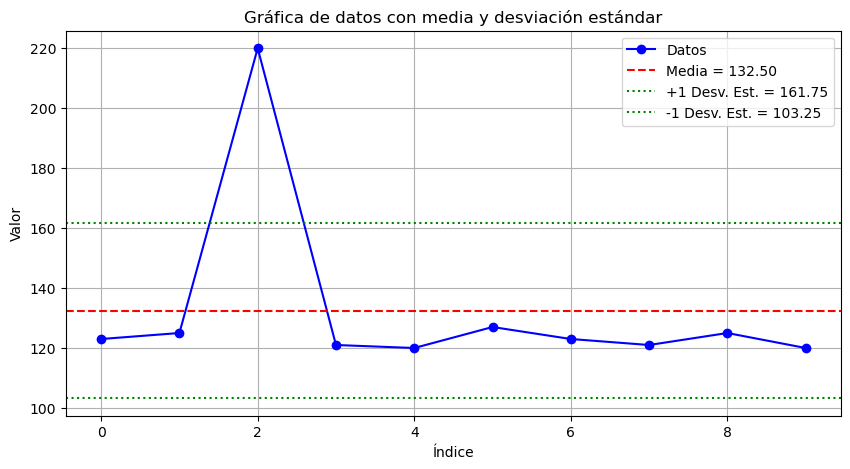

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Datos originales
datos = [123, 125, 220, 121, 120, 127, 123, 121, 125, 120]

# Calcular la media y la desviación estándar
media = np.mean(datos)
desviacion_estandar = np.std(datos)

# Crear la gráfica
plt.figure(figsize=(10, 5))
plt.plot(datos, marker='o', label='Datos', linestyle='-', color='blue')
plt.axhline(y=media, color='red', linestyle='--', label=f'Media = {media:.2f}')
plt.axhline(y=media + desviacion_estandar, color='green', linestyle=':', label=f'+1 Desv. Est. = {media + desviacion_estandar:.2f}')
plt.axhline(y=media - desviacion_estandar, color='green', linestyle=':', label=f'-1 Desv. Est. = {media - desviacion_estandar:.2f}')

# Configuración de la gráfica
plt.title('Gráfica de datos con media y desviación estándar')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

## Filtro pasa bajo (Low-pass filter)

El filtro pasa bajo es una técnica que permite pasar frecuencias bajas y atenúa las frecuencias más altas (como el ruido). Se usa para suavizar la señal sin tener que almacenar un buffer completo de lecturas. Suele estar basado en ecuaciones diferenciales o técnicas discretas como:

$$
y[n] = \alpha \cdot x[n] + (1 - \alpha) \cdot y[n-1]
$$

Donde:

- $ x[n] $: Entrada en el instante actual.
- $ y[n-1] $: Salida previa.
- $ \alpha $: Parámetro que controla el grado de suavizado.

Un poco más simple:

$$
\text{Salida} = \alpha \cdot \text{Entrada nueva} + (1 - \alpha) \cdot \text{Salida anterior}
$$
Donde $\alpha$ es el factor de suavizado (entre 0 y 1).

**Ejemplo de implementación en Arduino:**

In [ ]:
float filtroPasaBajo(float entradaNueva, float salidaAnterior, float alpha) {
  return alpha * entradaNueva + (1 - alpha) * salidaAnterior;
}

Aquí, un valor de $\alpha$ más bajo produce una mayor suavización, mientras que un $\alpha$ más alto responde más rápido a los cambios.

**Ejemplo en Python:**

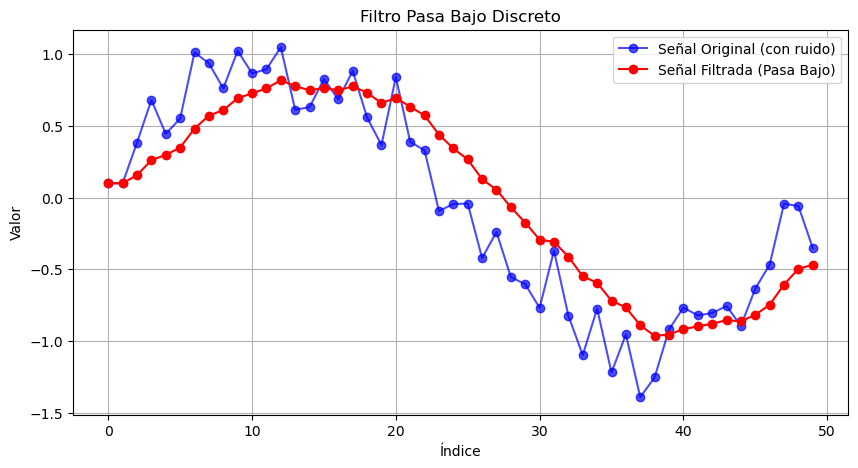

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del filtro
alpha = 0.2  # Factor de suavizado, similar a la frecuencia de corte
# Valores más bajos de alpha permiten más suavizado (mayor atenuación de altas frecuencias).

# Datos originales (ejemplo con ruido)
np.random.seed(42)  # Para reproducibilidad
datos = np.sin(np.linspace(0, 2 * np.pi, 50)) + np.random.normal(0, 0.2, 50)

# Implementación del filtro pasa bajo
def filtro_pasabajo(datos, alpha):
    filtrados = [datos[0]]  # Inicializar con el primer valor
    for i in range(1, len(datos)):
        filtrados.append(alpha * datos[i] + (1 - alpha) * filtrados[-1])
    return filtrados

# Aplicar el filtro
datos_filtrados = filtro_pasabajo(datos, alpha)

# Gráfica de la señal original y filtrada
plt.figure(figsize=(10, 5))
plt.plot(datos, marker='o', linestyle='-', label='Señal Original (con ruido)', color='blue', alpha=0.7)
plt.plot(datos_filtrados, marker='o', linestyle='-', label='Señal Filtrada (Pasa Bajo)', color='red')
plt.title('Filtro Pasa Bajo Discreto')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

## Filtro de la mediana móvil

El filtro de la mediana móvil es similar a la media móvil, pero en lugar de promediar los valores, toma la mediana de los últimos `n` datos. Esto es útil para eliminar picos o valores atípicos.

**Ejemplo de implementación en Arduino:**

In [ ]:
float filtroMedianaMovil(float nuevoDato, float* buffer, int n) {
  // Desplazar el buffer
  for (int i = n - 1; i > 0; i--) {
    buffer[i] = buffer[i - 1];
  }
  buffer[0] = nuevoDato;

  // Copiar el buffer y ordenarlo
  float temp[n];
  for (int i = 0; i < n; i++) {
    temp[i] = buffer[i];
  }

  // Ordenar para encontrar la mediana
  for (int i = 0; i < n - 1; i++) {
    for (int j = i + 1; j < n; j++) {
      if (temp[i] > temp[j]) {
        float t = temp[i];
        temp[i] = temp[j];
        temp[j] = t;
      }
    }
  }

  // Si n es impar, devolver el elemento del centro
  if (n % 2 == 1) {
    return temp[n / 2];
  } 
  // Si n es par, devolver el promedio de los dos del centro
  else {
    return (temp[(n - 1) / 2] + temp[n / 2]) / 2.0;
  }
}

**Ejemplo en Python:**

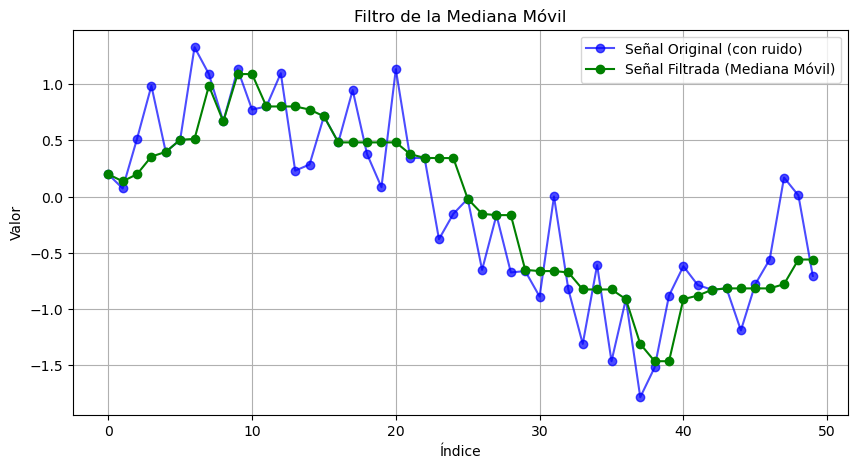

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Implementación del filtro de la mediana móvil
def filtro_mediana_movil(datos, ventana):
    filtrados = []
    buffer = [0] * ventana  # Buffer inicializado
    for i, nuevo_dato in enumerate(datos):
        # Desplazar el buffer
        buffer = [nuevo_dato] + buffer[:-1]
        
        # Calcular la mediana
        if i < ventana - 1:
            # Para los primeros elementos, solo se usa la ventana disponible
            filtrados.append(np.median(buffer[:i + 1]))
        else:
            filtrados.append(np.median(buffer))
    return filtrados

# Datos originales con ruido
np.random.seed(42)
datos = np.sin(np.linspace(0, 2 * np.pi, 50)) + np.random.normal(0, 0.4, 50)

# Tamaño de la ventana
ventana = 5

# Aplicar el filtro de mediana móvil
datos_filtrados = filtro_mediana_movil(datos, ventana)

# Crear la gráfica
plt.figure(figsize=(10, 5))
plt.plot(datos, marker='o', linestyle='-', label='Señal Original (con ruido)', color='blue', alpha=0.7)
plt.plot(datos_filtrados, marker='o', linestyle='-', label='Señal Filtrada (Mediana Móvil)', color='green')
plt.title('Filtro de la Mediana Móvil')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

## Filtro de Kalman

El filtro de Kalman es un filtro óptimo que se utiliza para sistemas dinámicos y es ideal para trabajar con datos de sensores que pueden ser inestables o ruidosos. Aunque más complejo que los anteriores, es extremadamente efectivo. La implementación del filtro de Kalman es más avanzada y depende de factores como la predicción del estado del sistema y la corrección del ruido de los sensores. A continuación una versión básica:

**Ejemplo de implementación en Arduino:**

In [ ]:
struct FiltroKalman {
  float Q; // Varianza del proceso
  float R; // Varianza de la medida
  float X; // Valor estimado
  float P; // Error estimado
  float K; // Ganancia de Kalman
};

void inicializarKalman(FiltroKalman &filtro, float Q, float R, float valorInicial) {
  filtro.Q = Q;
  filtro.R = R;
  filtro.X = valorInicial;
  filtro.P = 1;
}

float aplicarFiltroKalman(FiltroKalman &filtro, float medida) {
  // Predicción
  filtro.P = filtro.P + filtro.Q;

  // Ganancia de Kalman
  filtro.K = filtro.P / (filtro.P + filtro.R);

  // Actualización de la estimación
  filtro.X = filtro.X + filtro.K * (medida - filtro.X);

  // Actualización del error estimado
  filtro.P = (1 - filtro.K) * filtro.P;

  return filtro.X;
}

**Ejemplo en Python:**

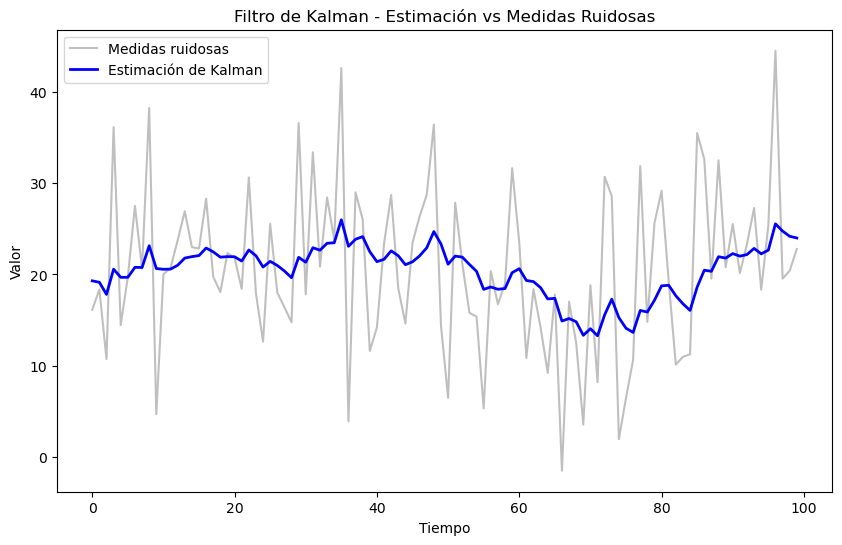

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class FiltroKalman:
    def __init__(self, Q, R, valor_inicial):
        self.Q = Q  # Varianza del proceso
        self.R = R  # Varianza de la medida
        self.X = valor_inicial  # Valor estimado
        self.P = 1  # Error estimado
        self.K = 0  # Ganancia de Kalman

    def aplicar(self, medida):
        # Predicción
        self.P = self.P + self.Q

        # Ganancia de Kalman
        self.K = self.P / (self.P + self.R)

        # Actualización de la estimación
        self.X = self.X + self.K * (medida - self.X)

        # Actualización del error estimado
        self.P = (1 - self.K) * self.P

        return self.X

# Datos de ejemplo
medidas = [20 + np.random.normal(0, 10) for _ in range(100)]  # Ruido agregado a las mediciones
kalman = FiltroKalman(Q=0.1, R=5, valor_inicial=20)

# Aplicar el filtro de Kalman a las medidas
estimaciones = [kalman.aplicar(m) for m in medidas]

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(medidas, label="Medidas ruidosas", color='gray', alpha=0.5)
plt.plot(estimaciones, label="Estimación de Kalman", color='blue', linewidth=2)
plt.title("Filtro de Kalman - Estimación vs Medidas Ruidosas")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.legend()
plt.show()